In [3]:
from fastapi import FastAPI, File, UploadFile
from tensorflow.keras.models import load_model
import numpy as np
import cv2
from io import BytesIO
import nest_asyncio
import uvicorn


2025-03-19 17:58:53.513759: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-19 17:58:53.575943: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-19 17:58:53.896149: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-19 17:58:56.621830: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
nest_asyncio.apply()


In [5]:
app = FastAPI()

In [6]:
#model_path = "/home/vinodha/code/CptSAmerica/Space_Gem/notebooks/model_v2_1.keras"
#model = load_model(model_path)
#model.summary()

In [7]:
absolute_path = "model_v2_1.keras"
model = load_model(absolute_path)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 255, 255, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 87)             │         5,655 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,685,991 (48.39 MB)

 Trainable params: 4,228,663 (16.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,457,328 (32.26 MB)

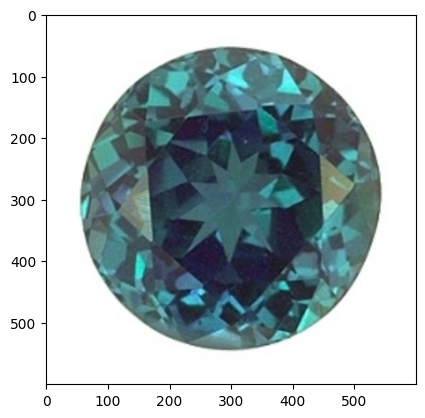

In [8]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
image = load_img('alexandrite_18.jpg')

# Convert to array
image_array = img_to_array(image)  # Shape: (height, width, channels)

# Normalize to [0, 1]
image_array = image_array / 255.0

# Resize if necessary
from tensorflow.image import resize
image_array = resize(image_array, [600, 600])  # Resize to 224x224

# Add batch dimension (required for models)
image_array = np.expand_dims(image_array, axis=0) 

import matplotlib.pyplot  as plt

plt.imshow(image_array[0], cmap='gray')


In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
#preprocessing
def preprocess_image(image_bytes):
    
    #image_array = np.asarray(image_bytes, dtype=np.uint8)
    #img = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = img / 255.0  # Normalize pixel values
    #img = np.expand_dims(img, axis=0)  # Expand dimensions
    img = img_to_array(image_bytes)
    #img = cv2.resize(img, (255, 255)) 
    img = resize(img, (255, 255))  
    return img


#from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
# Create train and test dir paths
#train_data_dir = '/kaggle/input/gemstones-images/train'
#test_data_dir = '/kaggle/input/gemstones-images/test'
img = load_img('/kaggle/input/gemstones-images/train/Cats Eye/cats eye_11.jpg')
X = img_to_array(img)
img

In [23]:
# mapping
if "class_indices" in dir(model):
    gemstone_classes = {v: k for k, v in model.class_indices.items()}
else:
    gemstone_classes = {i: f"Gemstone_{i}" for i in range(87)}  

print(gemstone_classes)


{0: 'Gemstone_0', 1: 'Gemstone_1', 2: 'Gemstone_2', 3: 'Gemstone_3', 4: 'Gemstone_4', 5: 'Gemstone_5', 6: 'Gemstone_6', 7: 'Gemstone_7', 8: 'Gemstone_8', 9: 'Gemstone_9', 10: 'Gemstone_10', 11: 'Gemstone_11', 12: 'Gemstone_12', 13: 'Gemstone_13', 14: 'Gemstone_14', 15: 'Gemstone_15', 16: 'Gemstone_16', 17: 'Gemstone_17', 18: 'Gemstone_18', 19: 'Gemstone_19', 20: 'Gemstone_20', 21: 'Gemstone_21', 22: 'Gemstone_22', 23: 'Gemstone_23', 24: 'Gemstone_24', 25: 'Gemstone_25', 26: 'Gemstone_26', 27: 'Gemstone_27', 28: 'Gemstone_28', 29: 'Gemstone_29', 30: 'Gemstone_30', 31: 'Gemstone_31', 32: 'Gemstone_32', 33: 'Gemstone_33', 34: 'Gemstone_34', 35: 'Gemstone_35', 36: 'Gemstone_36', 37: 'Gemstone_37', 38: 'Gemstone_38', 39: 'Gemstone_39', 40: 'Gemstone_40', 41: 'Gemstone_41', 42: 'Gemstone_42', 43: 'Gemstone_43', 44: 'Gemstone_44', 45: 'Gemstone_45', 46: 'Gemstone_46', 47: 'Gemstone_47', 48: 'Gemstone_48', 49: 'Gemstone_49', 50: 'Gemstone_50', 51: 'Gemstone_51', 52: 'Gemstone_52', 53: 'Gemston

In [24]:
import json

gemstone_classes = [
    'Alexandrite', 'Almandine', 'Amazonite', 'Amber', 'Amethyst', 'Ametrine', 'Andalusite', 
    'Andradite', 'Aquamarine', 'Aventurine Green', 'Aventurine Yellow', 'Benitoite', 
    'Beryl Golden', 'Bixbite', 'Bloodstone', 'Blue Lace Agate', 'Carnelian', 'Cats Eye', 
    'Chalcedony', 'Chalcedony Blue', 'Chrome Diopside', 'Chrysoberyl', 'Chrysocolla', 
    'Chrysoprase', 'Citrine', 'Coral', 'Danburite', 'Diamond', 'Diaspore', 'Dumortierite', 
    'Emerald', 'Fluorite', 'Garnet Red', 'Goshenite', 'Grossular', 'Hessonite', 'Hiddenite', 
    'Iolite', 'Jade', 'Jasper', 'Kunzite', 'Kyanite', 'Labradorite', 'Lapis Lazuli', 
    'Larimar', 'Malachite', 'Moonstone', 'Morganite', 'Onyx Black', 'Onyx Green', 'Onyx Red', 
    'Opal', 'Pearl', 'Peridot', 'Prehnite', 'Pyrite', 'Pyrope', 'Quartz Beer', 'Quartz Lemon', 
    'Quartz Rose', 'Quartz Rutilated', 'Quartz Smoky', 'Rhodochrosite', 'Rhodolite', 'Rhodonite', 
    'Ruby', 'Sapphire Blue', 'Sapphire Pink', 'Sapphire Purple', 'Sapphire Yellow', 'Scapolite', 
    'Serpentine', 'Sodalite', 'Spessartite', 'Sphene', 'Spinel', 'Spodumene', 'Sunstone', 
    'Tanzanite', 'Tigers Eye', 'Topaz', 'Tourmaline', 'Tsavorite', 'Turquoise', 'Variscite', 
    'Zircon', 'Zoisite'
]

json_file_path = "/home/vinodha/code/CptSAmerica/Space_Gem/notebooks/gemstone_classes.json"

with open(json_file_path, "w") as f:
    json.dump(gemstone_classes, f, indent=4)

print(json_file_path)

/home/vinodha/code/CptSAmerica/Space_Gem/notebooks/gemstone_classes.json


In [25]:
json_path = "/home/vinodha/code/CptSAmerica/Space_Gem/notebooks/gemstone_classes.json"

with open(json_path, "r") as f:
    gemstone_classes = json.load(f)

print(gemstone_classes)


['Alexandrite', 'Almandine', 'Amazonite', 'Amber', 'Amethyst', 'Ametrine', 'Andalusite', 'Andradite', 'Aquamarine', 'Aventurine Green', 'Aventurine Yellow', 'Benitoite', 'Beryl Golden', 'Bixbite', 'Bloodstone', 'Blue Lace Agate', 'Carnelian', 'Cats Eye', 'Chalcedony', 'Chalcedony Blue', 'Chrome Diopside', 'Chrysoberyl', 'Chrysocolla', 'Chrysoprase', 'Citrine', 'Coral', 'Danburite', 'Diamond', 'Diaspore', 'Dumortierite', 'Emerald', 'Fluorite', 'Garnet Red', 'Goshenite', 'Grossular', 'Hessonite', 'Hiddenite', 'Iolite', 'Jade', 'Jasper', 'Kunzite', 'Kyanite', 'Labradorite', 'Lapis Lazuli', 'Larimar', 'Malachite', 'Moonstone', 'Morganite', 'Onyx Black', 'Onyx Green', 'Onyx Red', 'Opal', 'Pearl', 'Peridot', 'Prehnite', 'Pyrite', 'Pyrope', 'Quartz Beer', 'Quartz Lemon', 'Quartz Rose', 'Quartz Rutilated', 'Quartz Smoky', 'Rhodochrosite', 'Rhodolite', 'Rhodonite', 'Ruby', 'Sapphire Blue', 'Sapphire Pink', 'Sapphire Purple', 'Sapphire Yellow', 'Scapolite', 'Serpentine', 'Sodalite', 'Spessartite

In [13]:
def get_gemstone_label(prediction_index):

    if 0 <= prediction_index < len(gemstone_classes):
        return gemstone_classes[prediction_index]
    else:
        return "Unknown Gemstone"



In [26]:
#testing
prediction_index = 3  
predicted_label = get_gemstone_label(prediction_index)
print(f"Predicted Gemstone: {predicted_label}")


Predicted Gemstone: Amber


In [15]:
!pwd

/home/vinodha/code/CptSAmerica/Space_Gem/notebooks


In [27]:
image_path = "\home\vinodha\code\CptSAmerica\Space_Gem\notebooks\alexandrite_18.jpg" 
processed_img = preprocess_image(image_path)
print (processed_img)

ValueError: could not convert string to float: '\\home\x0binodha\\code\\CptSAmerica\\Space_Gem\notebooks\x07lexandrite_18.jpg'

In [17]:
prediction = model.predict(processed_img)
predicted_class_index = np.argmax(prediction[0])  
predicted_label = get_gemstone_label(predicted_class_index)


NameError: name 'processed_img' is not defined

In [18]:
#@app.post("/predict/")
def predict(file: UploadFile = File(...)):
    img = preprocess_image(await file.read())
    prediction = model.predict(img)
    predicted_class_index = np.argmax(prediction[0])  #predict class index
    predicted_class_name = gemstone_classes[str(predicted_class_index)] #mapping
    return {"predicted_gemstone": predicted_class_name}

SyntaxError: 'await' outside async function (3201252626.py, line 3)

In [19]:
prediction = predict('alexandrite_18.jpg')

NameError: name 'predict' is not defined

In [20]:
prediction

NameError: name 'prediction' is not defined

In [21]:
preprocessed_img = preprocess_image('alexandrite_18.jpg')

ValueError: could not convert string to float: 'alexandrite_18.jpg'

In [53]:
with open(image_path, 'rb') as f:
    image_bytes = f.read()

FileNotFoundError: [Errno 2] No such file or directory: '\\home\x0binodha\\code\\CptSAmerica\\Space_Gem\raw_data\x07lexandrite_18.jpg'